# Metrics JSONL Analysis Notebook
This notebook loads a `calls_metrics.jsonl` file generated by the `openai_client` wrapper and produces:
- Overall averages for throughput and timing metrics
- Per‑minute trend plots (tokens, RPM, latency, retries)
- Error counts and percentages

## File Selection


### Choose manually
run the first cell
use the dropdown
then run the second cell
if you ever want to change it then you must change the dropdown and run the second cell again

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path

# Set the directory containing your metrics files
metrics_dir = Path.cwd() 
jsonl_files = list(metrics_dir.glob("*.jsonl"))

if not jsonl_files:
    print("No .jsonl files found in this directory.")
else:
    file_dropdown = widgets.Dropdown(
        options=[(f.name, f) for f in jsonl_files],
        description='Select file:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    display(file_dropdown)

    # Example: get the selected file path
    def on_file_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print(f"Selected file: {change['new']}")

    file_dropdown.observe(on_file_change)
    print(file_dropdown.value)

Dropdown(description='Select file:', layout=Layout(width='50%'), options=(('clinical_trial_calls_20250504_1844…

c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_184415 copy.jsonl


if you change something from the above dropdown make sure to also run the line below to set it in stone

In [ ]:
metrics_path = file_dropdown.value
print(f"Selected file: {metrics_path}")

Selected file: c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_184415 copy.jsonl


### latest time stamped file
if instead you just want the latest run then run this cell below

In [72]:
from pathlib import Path
import re

# Set the directory containing your metrics files
metrics_dir = Path.cwd()  # or Path to your metrics directory

# Regex to match the filename pattern and extract the timestamp
pattern = re.compile(r"clinical_trial_calls_(\d{8}_\d{6})\.jsonl")

# Find all matching files and extract their timestamps
files_with_timestamps = []
for f in metrics_dir.glob("clinical_trial_calls_*.jsonl"):
    if m := pattern.match(f.name):
        files_with_timestamps.append((m[1], f))

if not files_with_timestamps:
    print("No matching .jsonl files found.")
else:
    # Sort by timestamp (descending) and pick the latest
    latest_file = max(files_with_timestamps, key=lambda x: x[0])[1]
    print(f"Latest metrics file: {latest_file}")
    metrics_path = latest_file

Latest metrics file: c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_203410.jsonl


### verify you have the right file

In [50]:
print(metrics_path)

c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_203410.jsonl


## Start the actual analysis

load in the file

In [84]:
import pandas as pd
from matplotlib import pyplot as plt

assert metrics_path.exists(), f'File not found: {metrics_path}'
df = pd.read_json(metrics_path, lines=True, convert_dates=['ts'])
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.set_index('ts', inplace=True)
print(f'Loaded {len(df):,} call records')

Loaded 13,299 call records


### Per call

In [85]:

df_reset = df.reset_index().rename(columns={'ts': 'timestamp'})
df_reset['call_id'] = range(len(df_reset))

Token metrics

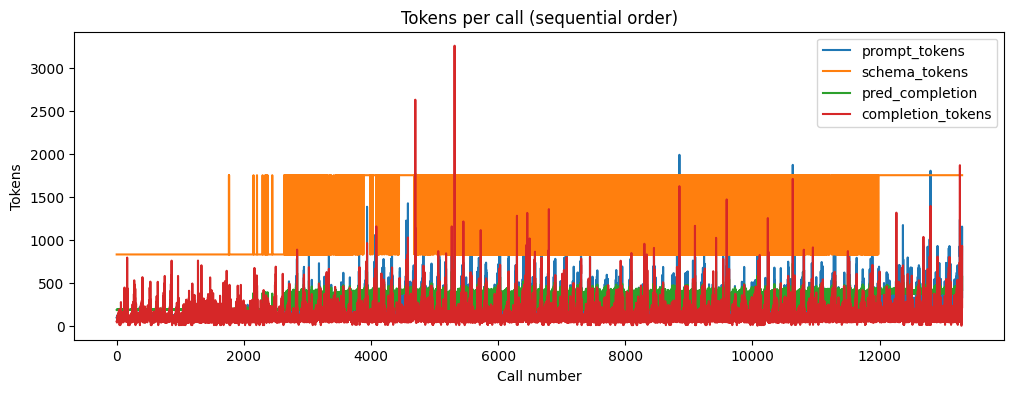

In [86]:
plt.figure(figsize=(12,4))
df_reset.plot(
    x='call_id',
    y=['prompt_tokens', 'schema_tokens', 'pred_completion', 'completion_tokens'],
    ax=plt.gca()
)
plt.title('Tokens per call (sequential order)')
plt.xlabel('Call number')
plt.ylabel('Tokens')
plt.show()

Latency and retries

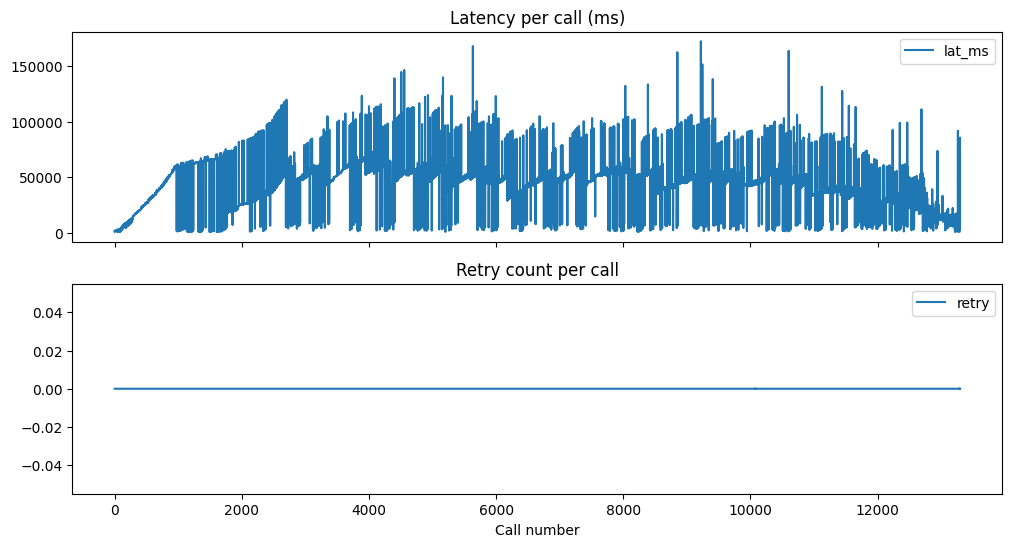

In [87]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))
df_reset.plot(x='call_id', y='lat_ms', ax=ax[0])
ax[0].set_title('Latency per call (ms)')
df_reset.plot(x='call_id', y='retry', ax=ax[1])
ax[1].set_title('Retry count per call')
ax[1].set_xlabel('Call number')
plt.show()

Errors

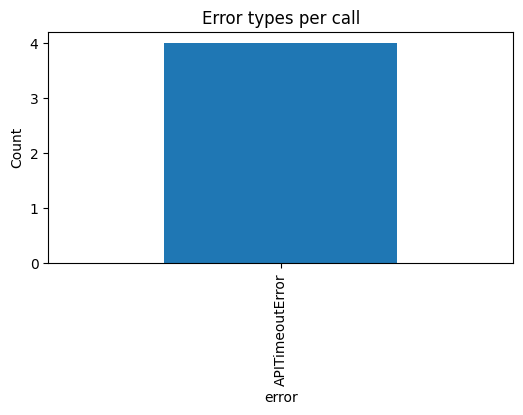

In [88]:
err_nonnull = df_reset['error'].dropna()

if err_nonnull.empty:
    print("✅  No errors recorded in this run.")
else:
    err_counts = err_nonnull.value_counts()
    err_counts.plot(kind='bar', figsize=(6,3), title='Error types per call')
    plt.ylabel('Count')
    plt.show()


### Per minute

In [94]:
df_1s = df.resample('1s').agg({
    'total_tokens': 'sum',
    'retry': 'size',              # each call = 1
    'lat_ms': 'mean'
}).fillna(0)

# rolling 60‑second sums / means
sliding = pd.DataFrame({
    'tpm'      : df_1s['total_tokens'].rolling('60s').sum(),
    'rpm'      : df_1s['retry'].rolling('60s').sum(),
    'latency'  : df_1s['lat_ms'].rolling('60s').mean()
})

sliding.head()

,tpm,rpm,latency
ts,,,
2025-05-05 00:34:22,35548.0,35.0,1690.140000
2025-05-05 00:34:23,81857.0,80.0,1945.224444
2025-05-05 00:34:24,102414.0,100.0,2139.672963
2025-05-05 00:34:25,115815.0,113.0,2442.214338
2025-05-05 00:34:26,130420.0,126.0,2789.714547


In [90]:
# Overall averages and error stats
overall_avg = minute[['tpm','rpm','retries','latency_ms','prompt_tokens',
                      'schema_tokens','pred_completion','completion_tokens',
                      'pred_err','prompt_cached','sem_capacity']].mean()

error_total = df['error'].notna().sum()
error_pct = 100 * error_total / len(df)

print('=== OVERALL AVERAGES ===')
print(overall_avg.round(2))
print(f'\nTotal error lines: {error_total}  ({error_pct:.2f}% of all calls)')


=== OVERALL AVERAGES ===
tpm                  1696228.46
rpm                     1023.00
retries                    0.00
latency_ms             40664.95
prompt_tokens            207.33
schema_tokens           1333.73
pred_completion          307.79
completion_tokens        142.02
pred_err                -165.77
prompt_cached            969.66
sem_capacity             100.00
dtype: float64

Total error lines: 4  (0.03% of all calls)


<Figure size 1000x500 with 0 Axes>

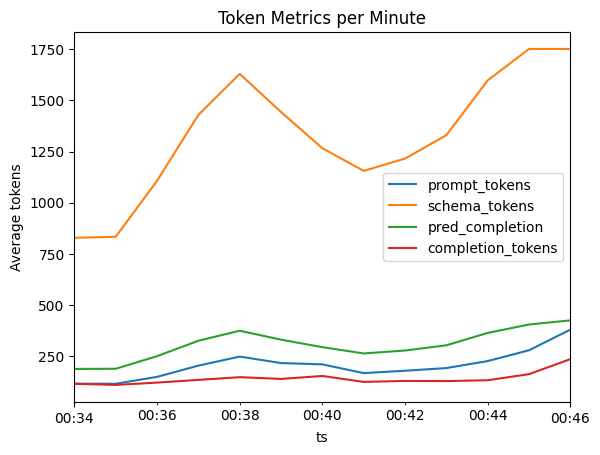

In [91]:
from matplotlib import pyplot as plt
# Token metrics in one chart
plt.figure(figsize=(10,5))
minute[['prompt_tokens','schema_tokens','pred_completion','completion_tokens']].plot()
plt.title('Token Metrics per Minute')
plt.ylabel('Average tokens')
plt.show()


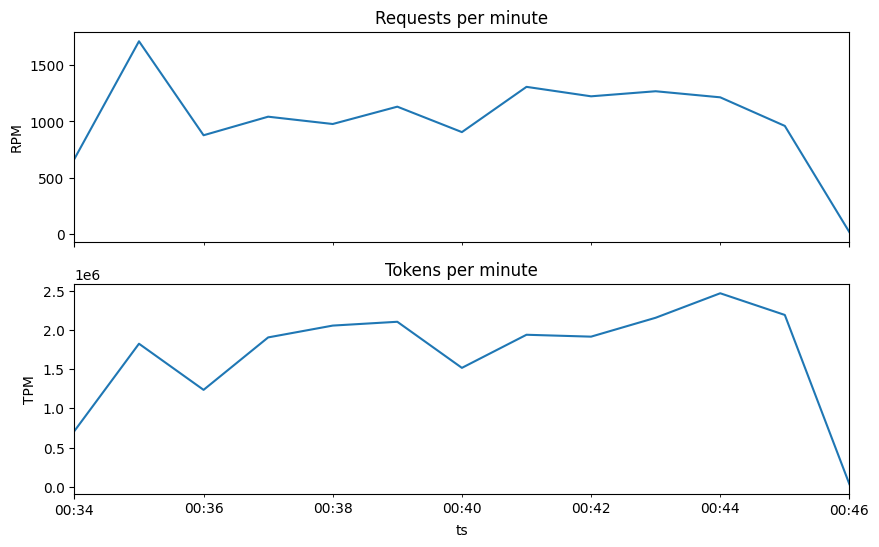

In [92]:
# RPM and TPM
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
minute['rpm'].plot(ax=ax[0])
ax[0].set_title('Requests per minute')
ax[0].set_ylabel('RPM')

minute['tpm'].plot(ax=ax[1])
ax[1].set_title('Tokens per minute')
ax[1].set_ylabel('TPM')
plt.show()


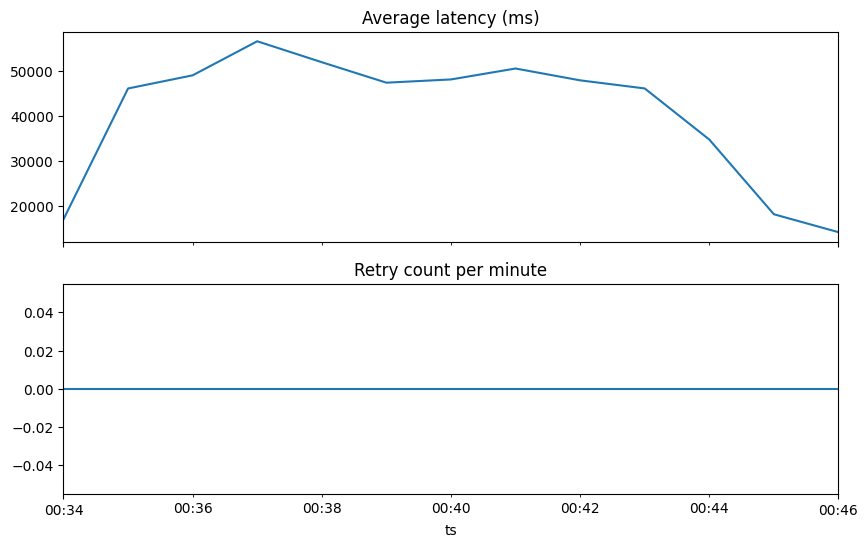

In [93]:
# Latency and retries
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
minute['latency_ms'].plot(ax=ax[0])
ax[0].set_title('Average latency (ms)')

minute['retries'].plot(ax=ax[1])
ax[1].set_title('Retry count per minute')
plt.show()
